In [1]:
import nltk as nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jack\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jack\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Reading and formatting training data

In [2]:
import pandas as pd
import nltk as nltk

pd.set_option("max_colwidth", 200)
data = pd.read_csv("fake_or_real_news.csv")

# Removing unused column

data = data.drop(labels = "Unnamed: 0", axis = 1)

# Labelling remaining columns

data.columns=["title", "body_text", "label"]
data.head()

,title,body_text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. \nIn the final stretch of the election, Hillary Rodham Clinton has gone to wa...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Political Suicide At A Trump Rally (VIDEO),Google Pinterest Digg Linkedin Reddit Stumbleupon Print Delicious Pocket Tumblr \nThere are two fundamental truths in this world: Paul Ryan desperately wants to be president. And Paul Ryan will ne...,FAKE
2,Kerry to go to Paris in gesture of sympathy,"U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.\n\nKerr...",REAL
3,Bernie supporters on Twitter erupt in anger against the DNC: 'We tried to warn you!',"— Kaydee King (@KaydeeKing) November 9, 2016 The lesson from tonight's Dem losses: Time for Democrats to start listening to the voters. Stop running the same establishment candidates. \n— People F...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners Hillary Clinton and Donald Trump are leading in the polls.\n\nTrump is now vowing to win enough delegates to clinch the Republican nomination and pre...,REAL


## Creating a preprocessing function which removes punctuations, tokenizes text, removes stop words, and lemmatizes text

In [3]:
import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

lemmatizer = WordNetLemmatizer()
ps = nltk.PorterStemmer()

def remove_punctuation(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    return text 

def tokenize(text):
    text = re.split('\W+', text)
    return text

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word not in stop_words]
    return text

def lemmatize(text):
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

def pre_process_data(text):
    text = remove_punctuation(text)
    text = tokenize(text)
    text = remove_stop_words(text)
    text = lemmatize(text)
    return text

## Vectorizing training data using TF-IDF

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime

tfidf_vectorizer = TfidfVectorizer(analyzer=pre_process_data)
tfidf_vector_fit = tfidf_vectorizer.fit(data['body_text'])
tfidf_training_vector = tfidf_vectorizer.transform(data['body_text'])
x_tfidf_features = pd.DataFrame(tfidf_training_vector.toarray()) 
testlabels = data['label']

## Training Linear SVM model

In [5]:
from sklearn import svm

startTime = datetime.now()

linear_svm = svm.SVC(kernel='linear')
linear_svm_model = linear_svm.fit(x_tfidf_features, testlabels)

print(datetime.now() - startTime)

0:32:00.964374


## Reading and formatting LIAR dataset 

In [6]:
# Reading both the train and test dataset

LIAR_train = pd.read_csv("liar_dataset/train.tsv", sep='\t', header=0)
LIAR_test = pd.read_csv("liar_dataset/test.tsv", sep='\t', header=0)

# Adding the column names to both dataset

LIAR_train.columns =["id", "label", "statement", "subject", "speaker", "job title", "state info", "party affiliation", "barely true counts", "false counts", "half true counts", "mostly true counts", "pants on fire counts", "context"]
LIAR_test.columns =["id", "label", "statement", "subject", "speaker", "job title", "state info", "party affiliation", "barely true counts", "false counts", "half true counts", "mostly true counts", "pants on fire counts", "context"]

# Concatenating the training and test dataset

LIAR_data = pd.concat([LIAR_train, LIAR_test], ignore_index=True, sort=False)

# Dropping rows that do not represent exactly 'true' or 'false' information

LIAR_data = LIAR_data.drop(LIAR_data.query('label == "half-true"').index)
LIAR_data = LIAR_data.drop(LIAR_data.query('label == "barely-true"').index)
LIAR_data = LIAR_data.drop(LIAR_data.query('label == "mostly-true"').index)
LIAR_data['label'] = LIAR_data['label'].replace(['true','false', 'pants-fire'], ['REAL', 'FAKE', 'FAKE'])

## Creating a function to balance the distribution of Fake and Real data in a dataset

In [7]:
def balance_distribution(dataset):
    fake_label_count = (dataset.label == 'FAKE').sum()
    real_label_count = (dataset.label == 'REAL').sum()

    if fake_label_count > real_label_count:
        distribution_diff = fake_label_count - real_label_count
        dataset = dataset.drop(dataset.query('label == "FAKE"').sample(n=distribution_diff).index)
        return dataset

    if real_label_count > fake_label_count:
        distribution_diff = real_label_count - fake_label_count
        dataset = dataset.drop(dataset.query('label == "REAL"').sample(n=distribution_diff).index)
        return dataset

## Balancing the distribution of Fake and Real data in the LIAR dataset

In [8]:
LIAR_data = balance_distribution(LIAR_data)

#print(LIAR_data['label'].value_counts())

## Vectorizing LIAR dataset using TF-IDF

In [9]:
LIAR_data_tfidf_vector = tfidf_vector_fit.transform(LIAR_data['statement'])

# Transforming sparce matrix into dataframe as model requires input in dataframe format

LIAR_data_test = pd.DataFrame(LIAR_data_tfidf_vector.toarray()) 

## Using trained model to produce classifications on LIAR dataset 

In [10]:
from sklearn.metrics import precision_recall_fscore_support as score

LIAR_data_predict = linear_svm_model.predict(LIAR_data_test)

precision, recall, fscore, support = score(LIAR_data.label, LIAR_data_predict, pos_label='FAKE', average='binary')

print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    precision, recall, (LIAR_data_predict==LIAR_data.label).sum()/len(LIAR_data_predict)))

Precision: 0.4919454770755886 / Recall: 0.6325013276686139 / Accuracy: 0.48964418481147104


## Creating a function to calculate outcome of predictions e.g. true postive, false positive etc.


In [11]:
def calculate_outcome(dataset, prediction_arr):
    dataset['predicted_label'] = prediction_arr
    dataset.loc[(dataset['label'] == 'REAL') & (dataset['predicted_label'] == 'REAL'), 'outcome'] = 'TN'
    dataset.loc[(dataset['label'] == 'REAL') & (dataset['predicted_label'] == 'FAKE'), 'outcome'] = 'FP'
    dataset.loc[(dataset['label'] == 'FAKE') & (dataset['predicted_label'] == 'REAL'), 'outcome'] = 'FN'
    dataset.loc[(dataset['label'] == 'FAKE') & (dataset['predicted_label'] == 'FAKE'), 'outcome'] = 'TP'

## Calculating the outcome of predictions on the LIAR dataset

In [12]:
calculate_outcome(LIAR_data, LIAR_data_predict)
#LIAR_data['outcome'].value_counts()

## Reading and formatting BuzzFeedNews dataset

In [13]:
import xml.etree.ElementTree as et 
import os
import pandas as pd 

rows_list = []
path = "buzzfeed_dataset/"

# Each datapoint in the BuzzFeedNews dataset comes as a seperate xml file
# Therefore I loop through the file directory and read each xml file, adding the contents of mainText 
# (contents of a news source) and veracity (label) to a dataframe

for filename in os.listdir(path):
    if filename.endswith('.xml'):
        fullname = os.path.join(path, filename)
        xtree = et.parse(fullname)
        xroot = xtree.getroot() 
        main_text = xroot.find('mainText').text
        veracity = xroot.find('veracity').text
        new_row = {'mainText': main_text, 'label': veracity}
        rows_list.append(new_row)

# Dropping rows that do not represent exactly 'true' or 'false' information

buzzfeed_data = pd.DataFrame(rows_list)   
buzzfeed_data = buzzfeed_data.drop(buzzfeed_data.query('label == "mixture of true and false"').index)

# Rename rows that represent 'true' and 'false' information to "REAL" and "FAKE" since the model is trained to classify to these

buzzfeed_data['label'] = buzzfeed_data['label'].replace(['mostly true','mostly false', 'no factual content'], ['REAL', 'FAKE', 'FAKE'])

# Drop any rows which have an empty body

buzzfeed_data.dropna(subset = ['mainText'], inplace=True)


## Balancing the distribution of Fake and Real data in the BuzzFeedNews dataset


In [14]:
buzzfeed_data = balance_distribution(buzzfeed_data)
#print(LIAR_buzzfeed_data['label'].value_counts())

## Vectorizing BuzzFeedNews dataset using TF-IDF

In [15]:
buzzfeed_data_tfidf_vector = tfidf_vector_fit.transform(buzzfeed_data['mainText'])

#Transforming sparce matrix into dataframe - model requires input as dataframe

buzzfeed_data_test = pd.DataFrame(buzzfeed_data_tfidf_vector.toarray()) 


## Using trained model to predicit labels of BuzzFeedNews dataset 


In [16]:
buzzfeed_data_predict = linear_svm_model.predict(buzzfeed_data_test)

precision, recall, fscore, support = score(buzzfeed_data.label, buzzfeed_data_predict, pos_label='FAKE', average='binary')

print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    precision, recall, (buzzfeed_data_predict==buzzfeed_data.label).sum()/len(buzzfeed_data_predict)))

Precision: 0.6707317073170732 / Recall: 0.7534246575342466 / Accuracy: 0.6917808219178082


## Calculating outcome of BuzzFeedNews predictions e.g. true postive, false positive 

In [17]:
calculate_outcome(buzzfeed_data, buzzfeed_data_predict)
#buzzfeed_data['outcome'].value_counts()

## Creating functions to get the 'Fakest' and 'Realest' terms in a dataset

In [18]:
#Storing all of unique words that the model was fitted on e.g. all of the unique words in the training dataset (McIntire)

features = tfidf_vector_fit.get_feature_names()

In [19]:
import numpy as np

def top_tfidf_feats(row, features, top_n=25):
    # Get top 25 tfidf values in row and return them with their corresponding feature names
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    # Adds top 25 tfidf values and associated column to dataframe
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [20]:
def top_mean_feats(tfidf_vector, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    # Return the top 25 features that on average are most important amongst documents in rows indentified by indices in grp_ids.
    
    # Adds all words in the tf_idf vector to an array
    if grp_ids:
        D = tfidf_vector[grp_ids].toarray()     
    else:
        D = tfidf_vector.toarray()        
    # Filters out words which occur commonly
    D[D < min_tfidf] = 0
    
    # Calculates the mean tfidf value for each word in the tfidf vector
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [21]:
def top_feats_by_outcome(tfidf_vector, dataset, features, min_tfidf=0.1, top_n=25):
    # Return a list of dfs, where each df holds top 25 features and their mean tfidf value
    # Calculated across documents with the same outcome e.g. true positive
    dfs = []
    outcomes = dataset.outcome.unique()
    outcomes = np.sort(outcomes)[::-1]
    for x in outcomes:
        ids = np.where(dataset.outcome==x)
        feats_df = top_mean_feats(tfidf_vector, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.outcome = x 
        dfs.append(feats_df)
    return dfs

In [22]:
import matplotlib.pyplot as plt

def plot_tfidf_outcome_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(2, len(dfs), i+1)
        ax.set_frame_on(False) # Removes border around graph
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("Outcome = " + str(df.outcome), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='black')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [23]:
def top_feats_by_label(tfidf_vector, dataset, features, min_tfidf=0.1, top_n=25):
    # Return a list of dfs, where each df holds top 25 features and their mean tfidf value
    # Calculated across documents with the same outcome e.g. true positive
    dfs = []
    labels = dataset.label.unique()
    for x in labels:
        ids = np.where(dataset.label==x)
        feats_df = top_mean_feats(tfidf_vector, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = x 
        dfs.append(feats_df)
    return dfs

In [24]:
def plot_tfidf_label_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(2, len(dfs), i+1)
        ax.set_frame_on(False) #removes border around graph
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='black')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        #plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

## The 25 highest averaged TF-IDF scores for terms in data with true positive, true negative, false positive, and false negative predictions in the BuzzFeedNews dataset. 

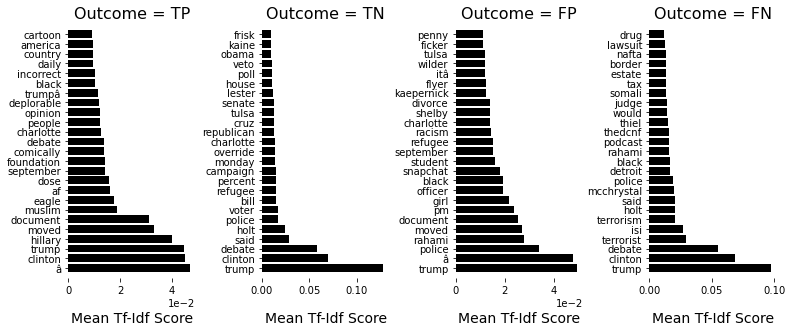

In [25]:
plot_tfidf_outcome_h(top_feats_by_outcome(buzzfeed_data_tfidf_vector, buzzfeed_data, features))

## The 25 highest averaged TF-IDF scores for terms in data with true positive, true negative, false positive, and false negative predictions in the LIAR dataset. 

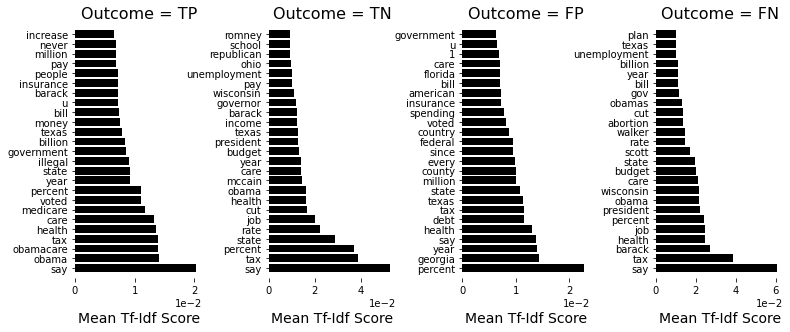

In [26]:
plot_tfidf_outcome_h(top_feats_by_outcome(LIAR_data_tfidf_vector, LIAR_data, features))

## The 25 highest averaged TF-IDF scores for terms labelled as “Fake” and “Real” in the training dataset. This represents the ‘fakest’ and ‘realest’ words that the model has learnt

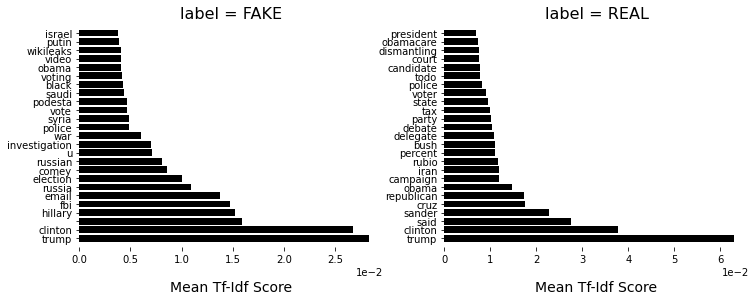

In [27]:
plot_tfidf_label_h(top_feats_by_label(tfidf_training_vector, data, features))